In [31]:
import numpy as np
import mat73
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2 as cv
from skimage import feature
from skimage.color import rgb2gray
import skimage.filters as filters
import sklearn.cluster as  Clusterer
from sklearn.metrics import silhouette_score

## Input
### Inputting frequency values

In [2]:
def input_gammas(path):
    rawdata = mat73.loadmat(path)
    st = rawdata['stPwrLfpTex'].astype(np.float32)
    bl = rawdata['blPwrLfpTex'].astype(np.float32)
    freq = rawdata['freqVals'].astype(np.float32)
    electrode_names = rawdata['LFPElectrodes'].astype(np.int64)

    st = np.transpose(st, (1, 0, 2))
    # images X Electrodes X Frequencies
    return st, bl, freq, electrode_names

path1 = "D:\\OneDrive - Indian Institute of Science\\5th Sem\\Summer project\\Data\\simple_data_v1\\textureColorStimuliPowerSp_alpaH_st_250_500_bl_-250_0_summerProject.mat"
path2 = "D:\\OneDrive - Indian Institute of Science\\5th Sem\\Summer project\\Data\\simple_data_v1\\RGB_texture_images_2.mat"
path3 = "Compressed_images.npz"
st, bl, freq, electrode_names = input_gammas(path1)


### Inputting images patches

In [3]:
def input_images(path, numpy_load=False):
    if numpy_load:
        rawdata = np.load(path)
        data = rawdata["masked_images"][:,:,285:370,300:385,:]
        return data
    else:
        rawdata = mat73.loadmat(path)
        data = (rawdata["masked_images"] * 255).astype(np.uint8)
        return data

#images = input_images(path2, numpy_load=False)
#np.savez_compressed(path3,masked_images=images)
images = input_images(path3, numpy_load=True)
n_images=images.shape[0]
n_electrodes=images.shape[1]

## Calculating Change in Power

In [4]:
def change_in_power(bl, st):
    delta_power = np.zeros(shape=st.shape)
    for i in range(st.shape[0]):
        delta_power[ i] = np.divide(st[i], bl)
    return delta_power


def change_in_gamma(bl,st,freq):
    delta_power = change_in_power(bl, st)
    indices=np.logical_and(freq >= 30, freq <= 80)

    del_gamma = np.zeros(shape=(delta_power.shape[0], delta_power.shape[1]))
    for i in range(delta_power.shape[0]):
        for j in range(delta_power.shape[1]):
            del_gamma[i][j]=np.sum(delta_power[i][j][indices])
            '''plt.plot(freq, delta_power[i][j])
            plt.xlim(0, 100)
            plt.show()'''
    return del_gamma
gamma_indices=indices=np.logical_and(freq >= 30, freq <= 80)
delta_power = change_in_power(bl, st)
delta_gamma = change_in_gamma(bl,st,freq)
delta_power_flat = np.resize(delta_power,new_shape=(delta_power.shape[0] * delta_power.shape[1], delta_power.shape[2]))
delta_gamma_flat=np.resize(delta_gamma, new_shape=(delta_gamma.shape[0] * delta_gamma.shape[1]))
images_flat=np.resize(images,new_shape=(images.shape[0]*images.shape[1],images.shape[2],images.shape[3],images.shape[4]))

## Ranking Images and by gamma response

In [5]:
ranking_patches=np.argsort(-delta_gamma_flat)
print(ranking_patches)
delta_gamma_images=np.average(delta_gamma, axis=1)
ranking_images=np.argsort(-delta_gamma_images)
print(ranking_images)

[ 385  421  169 ... 1144  783   66]
[ 5  2  7 12  1  9  6  3 13 11 10  8 14  0 15  4]


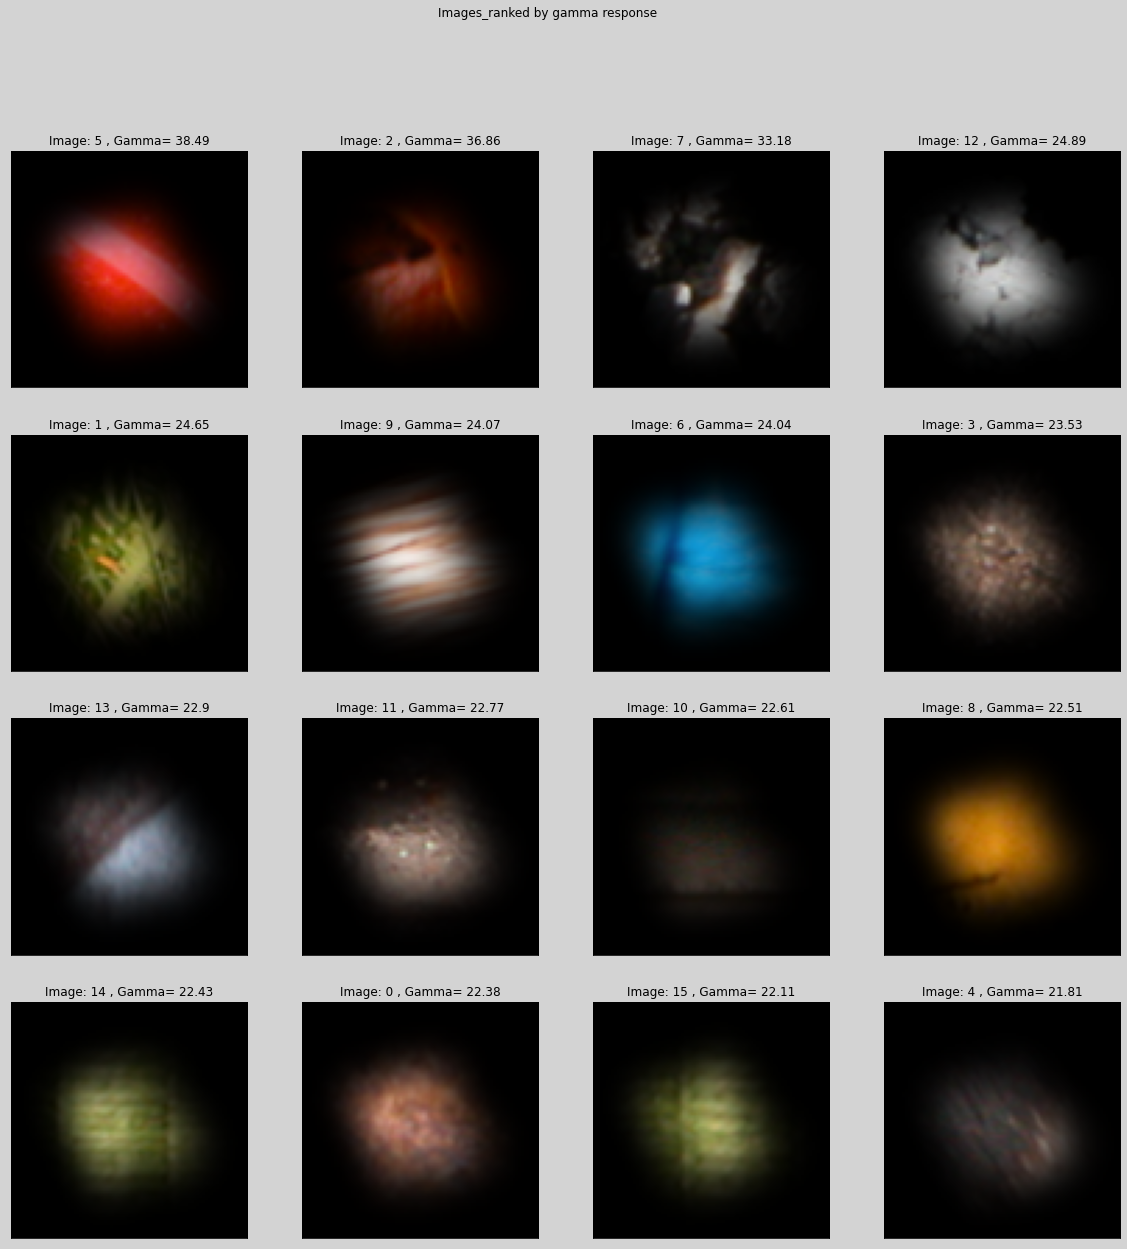

In [8]:
images_combined=(np.average(images,axis=1)*3).astype(int)
def rate_images(images_to_show, ranking, parameter, name):
    fig, ax = plt.subplots(4,4)
    fig.set_size_inches(20, 20)
    fig.set_facecolor('lightgray')
    fig.set_dpi=20000
    fig.suptitle(name)
    ax = ax.flatten()
    for i, axis in enumerate(ax):
        axis.imshow(images_to_show[ranking[i]])
        axis.set_title("Image: " + str(ranking[i]) + " , Gamma= " + str(round(parameter[ranking[i]], 2)))
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    plt.savefig("plots\\"+name+".png")
    plt.show()
rate_images(images_combined,ranking_images,delta_gamma_images,"Images_ranked by gamma response")

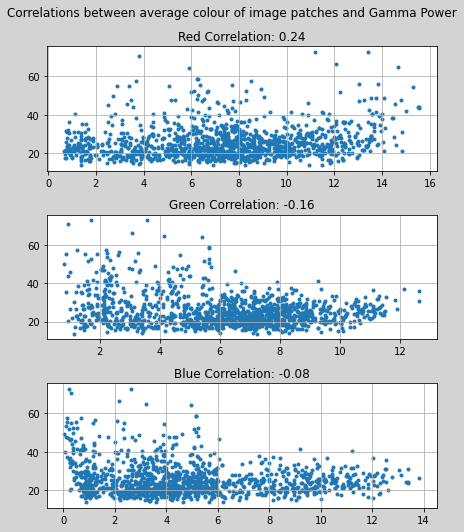

In [9]:
# to correlate the amount of Red in an image to the gamma power
def mini_rsquare_visualiser(x_array, y, x_label_array, ylabel, suptit, *, subtract_avg_0=False):
    n_plots=len(x_array)
    if subtract_avg_0:
        n_plots=len(x_array)-1
    fig, ax = plt.subplots(n_plots)
    fig.set_size_inches(6, n_plots*2.5)
    fig.set_dpi = 100
    fig.set_facecolor('lightgray')
    fig.suptitle(suptit)
    corr_avg=round(np.corrcoef(x_array[0], y)[0,1],3)*int(subtract_avg_0)
    j=int(subtract_avg_0)
    for i in range(0,n_plots):
        ax[i].scatter(x_array[j],y,marker='.')
        corr=round(np.corrcoef(x_array[j], y)[0,1]-corr_avg,2)
        ax[i].set_title(x_label_array[j]+" Correlation: "+str(corr))
        ax[i].grid(True)
        j+=1
    plt.tight_layout()
    plt.savefig("plots\\"+suptit+".png")
    plt.show()


RGB=np.average(images_flat[:, :, :, :], axis=(1, 2, 3))
[R,G,B]= [np.average(images_flat[:, :, :, i], axis=(1, 2)) for i in range(3)]
mini_rsquare_visualiser([RGB,R,G,B], delta_gamma_flat, ["Average","Red","Green","Blue"],"Gamma Power","Correlations between average colour of image patches and Gamma Power",
                        subtract_avg_0=True)
del RGB,R,G,B

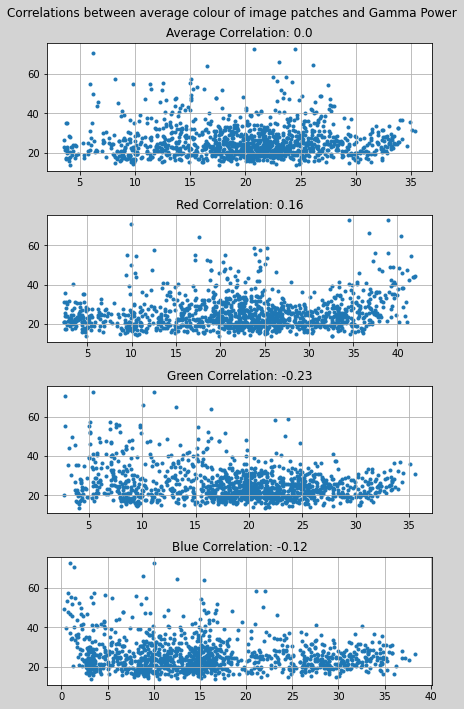

In [10]:
# Lets measure the standard deviation of RGB values in the image and correlate it with the gamma power

RGB_std=np.std(images_flat[:, :, :, :], axis=(1, 2, 3))
[R_std,G_std,B_std]= [np.std(images_flat[:, :, :, i], axis=(1, 2)) for i in range(3)]
mini_rsquare_visualiser([RGB_std,R_std,G_std,B_std], delta_gamma_flat, ["Average","Red","Green","Blue"],"Gamma Power","Correlations between average colour of image patches and Gamma Power")
del RGB_std,R_std,G_std,B_std

## Finding the edges of the images and correlating with gamma power

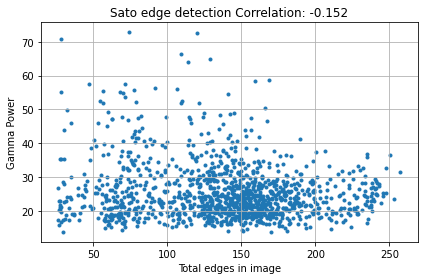

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

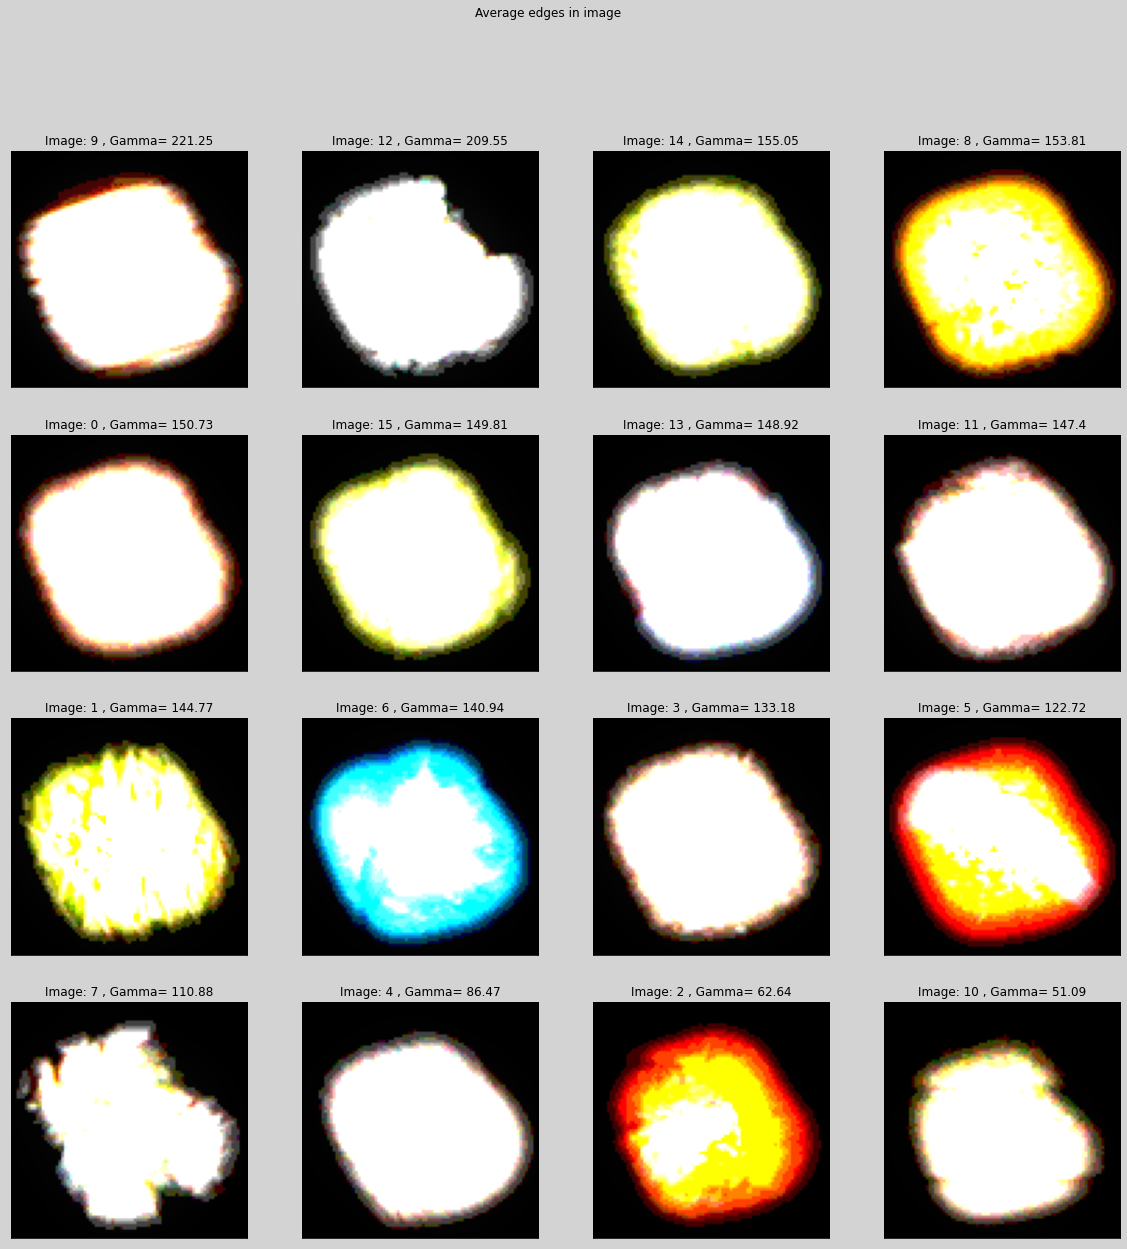

In [44]:
# detecting the edges of the images using opencv
def tiny_rsquare_visualiser(x_array, y, x_label_array, ylabel, suptit, ):
    plt.title(suptit)
    plt.xlabel(x_label_array)
    plt.ylabel(ylabel)
    plt.scatter(x_array,y,marker='.')
    corr=round(np.corrcoef(x_array, y)[0,1],3)
    plt.title(suptit+" Correlation: "+str(corr))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plots\\"+suptit+".png")
    plt.show()


edges_flat = np.zeros(shape=(images_flat.shape[0], images_flat.shape[1], images_flat.shape[2]))
for i in range(images_flat.shape[0]):
    edges_flat[i] = feature.canny(rgb2gray(images_flat[i]))
    edges_flat[i] = filters.sato(rgb2gray(images_flat[i]))
image_edges=np.array([np.average(edges_flat[i*n_electrodes:(i+1)*n_electrodes-1],axis=0) for i in range(n_images)])
total_edges=np.sum(edges_flat,axis=(1,2))
image_avg_edges=np.array([np.average(total_edges[i*n_electrodes:(i+1)*n_electrodes-1]) for i in range(n_images)])
tiny_rsquare_visualiser(total_edges, delta_gamma_flat, "Total edges in image","Gamma Power","Sato edge detection")
rank_edges=np.argsort(-image_avg_edges)
stacked=np.stack([image_edges,image_edges,image_edges],axis=-1)
rate_images(images_combined/4+stacked*3/4,rank_edges,image_avg_edges,"Average edges in image")

In [24]:
np.corrcoef(total_edges,delta_gamma_flat)

array([[ 1.        , -0.15159882],
       [-0.15159882,  1.        ]])

KMeans	0.677 2 [1 1 1 ... 1 1 1]


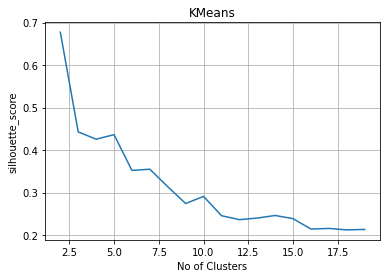

Agglomerative	0.692 2 [0 0 0 ... 0 0 0]


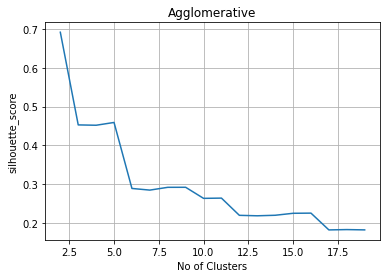

-	-	-	-



In [42]:
def cluster_grapher(k_vals, score_vals, name):
    # here we graph the scores for different values of k
    plt.plot(k_vals, score_vals)
    plt.grid(which='both')
    plt.title(name)
    plt.xlabel("No of Clusters")
    plt.ylabel("silhouette_score")
    plt.show()

def printer(kmeans_obj, score):
    print(round(score, 3), kmeans_obj.n_clusters, kmeans_obj.labels_)

def clustering_best_k(data, show=False, *, max_k=20, clustering_func=Clusterer.KMeans, name="KMeans"):
    if len(data.shape) > 2:
        data = np.reshape(data, np.prod(data.shape[1:]))
    best_clustering = None
    best_score = 0
    n_cluster = range(2, max_k)
    score_vals = np.zeros(len(n_cluster))

    for no_clusters in n_cluster:
        cluster = clustering_func(n_clusters=no_clusters).fit(data)
        labels = cluster.labels_
        score = silhouette_score(data, labels)
        score_vals[no_clusters - 2] = score
        # print(no_clusters, np.bincount(labels), score, kmeans.inertia_)
        if score > best_score:
            best_clustering = cluster
            best_score = score

    print(name,end='\t')
    printer(best_clustering, best_score)

    if show:
        cluster_grapher(n_cluster, score_vals, name)

    """bandwidth = Clusterer.estimate_bandwidth(data, quantile=0.2, n_samples=500)
    meanshift = Clusterer.MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(data)
    labels = meanshift.labels_
    score = silhouette_score(data, labels)
    printer(meanshift, score)"""

    return best_clustering, best_score


def clustering_function(data,*,show=False):
    kmeans_obj, score = clustering_best_k(data, show)
    aggl_obj,score=clustering_best_k(data,show,clustering_func=Clusterer.AgglomerativeClustering,name="Agglomerative")
    print("-\t-\t-\t-\n")
    return kmeans_obj,aggl_obj

kmeans_obj,aggl_obj=clustering_function(delta_power_flat[:,gamma_indices],show=True)


[0 1] [1102  130]


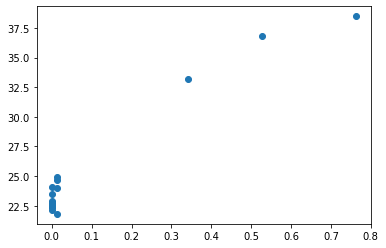

[0.0, 0.013157894736842105, 0.5263157894736842, 0.0, 0.013157894736842105, 0.7631578947368421, 0.013157894736842105, 0.34210526315789475, 0.0, 0.0, 0.0, 0.0, 0.013157894736842105, 0.0, 0.0, 0.0]


In [41]:
unique, counts = np.unique(kmeans_obj.labels_, return_counts=True)
print(unique,counts)
image_avg_responces=[np.average( kmeans_obj.labels_[n_electrodes*i:n_electrodes*(i+1)-1]) for i in range(n_images)]
plt.scatter(image_avg_responces, delta_gamma_images)
plt.show()
print(image_avg_responces)

# Neural Network

In [ ]:
##Neural Network to take the image and predict the gamma power
import torch as t
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self,n_channels=3):
        self.in_dim=85
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(in_channels=n_channels,out_channels=12,kernel_size=22)
        nn.init.kaiming_normal(self.conv1.weight)
        self.relu1=nn.ReLU()
        self.maxpool1=nn.MaxPool2d(kernel_size=8)
        self.out_conv_dim=int((1+int(self.in_dim-self.conv1.kernel_size[0]))//self.maxpool1.kernel_size)
        self.fc_in=self.conv1.out_channels*(self.out_conv_dim**2)
        self.fc1=nn.Linear(in_features=self.fc_in,out_features=24)
        nn.init.xavier_uniform(self.fc1.weight)
        self.relu3=nn.ReLU()
        self.fc3=nn.Linear(in_features=24,out_features=1)
        nn.init.xavier_uniform(self.fc3.weight)

    def forward(self,x):
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)
        x=x.view(1,self.fc_in)
        x=x.view(-1)
        x=self.fc1(x)
        x=self.relu3(x)
        x=self.fc3(x)
        return x
device = t.device("cuda" if t.cuda.is_available() else "cpu")
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.005)
criterion = nn.MSELoss()
num_epochs = 20
inpt=t.tensor(images_flat/2555,dtype=t.float32)
outpt=t.tensor(delta_gamma_flat,dtype=t.float32)
inpt=inpt.permute(0, 3, 1, 2)
for epoch in range(num_epochs):
    for i, data in enumerate(inpt):
        net.zero_grad()
        output = net(data)
        regularisation = 0*(0.01 * net.fc1.weight.norm(1) + 0.001*net.fc3.weight.norm(2))
        loss = criterion(output, outpt[i])+regularisation
        loss.backward()
        optimizer.step()
        if i == 1000:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(delta_power_flat), loss.item()))

            #we calculate the training loss for these 100 random images
            loss_avg=0
            for i in range(len(inpt)):
                output = net(inpt[i])
                loss = criterion(output, outpt[i])
                loss_avg+=loss.item()
            loss_avg/=len(inpt)
            print("Training loss:",loss_avg)

In [ ]:
net(inpt[2])


In [ ]:
output=np.array([float(net(i))for i in inpt])
# convert this to a numpy array

#Calculate the correlation between the predicted and the actual gamma power
corr=np.corrcoef(output,delta_gamma_flat)[0,1]

In [ ]:
'''class Net(nn.Module):
    def __init__(self,n_channels=3):

        super(Net, self).__init__()
        self.conv1=nn.Conv2d(in_channels=n_channels,out_channels=20,kernel_size=10)
        nn.init.kaiming_normal(self.conv1.weight)
        self.relu1=nn.ReLU()
        self.maxpool1=nn.MaxPool2d(kernel_size=4)

        self.conv2=nn.Conv2d(in_channels=20,out_channels=40,kernel_size=5)
        nn.init.kaiming_normal(self.conv2.weight)
        self.relu2=nn.ReLU()
        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        self.fc1=nn.Linear(in_features=40*7*7,out_features=200)
        nn.init.xavier_uniform(self.fc1.weight)
        self.relu3=nn.ReLU()
        self.fc2=nn.Linear(in_features=200,out_features=20)
        nn.init.xavier_uniform(self.fc2.weight)
        self.relu4=nn.ReLU()
        self.fc3=nn.Linear(in_features=20,out_features=1)
        nn.init.xavier_uniform(self.fc3.weight)
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.maxpool2(x)
        x=x.view(-1,40*7*7)
        x=self.fc1(x)
        x=self.relu3(x)
        x=self.fc2(x)
        x=self.relu4(x)
        x=self.fc3(x)
        return x'''